In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Importando as bibliotecas

In [2]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
import seaborn as sns

import re 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from ast import literal_eval
from collections import Counter
from itertools import chain

from nltk.tokenize import RegexpTokenizer

Lendo o arquivo

In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Retirando os espaços dos títulos das colunas para não atrapalhar

In [4]:
Coluna_name=[]
for i in df_train:
    Coluna_name.append(i.strip()) 
df_train.columns = Coluna_name 

Observando as dimensões dos dados de treino

In [5]:
print(f"Os dados de TREINO possui:")
print(f"{df_train.shape[0]} linhas")
print(f"{df_train.shape[1]} colunas\n")

Os dados de TREINO possui:
7613 linhas
5 colunas



In [6]:
# tipos dos dados
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
# colunas
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [8]:
# Estatística descritiva
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
# Valores nulos
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
# Excluindo as colunas com valores nulos
df_train = df_train.drop(columns=[ 'location',
                   'keyword'])

Criando uma função para fazer a limpeza dos dados, ela vai:

* Remover URL, números, pontuação, stopwords e palavras frequentes;
* Converte os caracteres para minúsculo e listas em string;
* Tokenização - separando as string de caracteres em tokens;
* Lematização - remove as desinências flexionais e retornar a forma básica de uma palavra;
* Stemming - redução de palavras derivadas.

In [11]:
# encontrando as palavras frequentes para remover depois 
from collections import Counter
cnt = Counter()
for text in df_train["text"].values:
    for word in text.split():
        cnt[word] += 1

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
stemmer = PorterStemmer()

def clean_review(text):
    text = re.sub(r'http\S+','', text)                              # URL
    text = re.sub('[^a-zA-Z]', ' ', text)                           # numeros e pontuações
    text = str(text).lower()                                        # converte o caracteres para minúsculo
    text = word_tokenize(text)                                      # tokenização
    text = [item for item in text if item not in stop_words]        # stopwords
    text = [lemma.lemmatize(word=w, pos='v') for w in text]         # lematização
    #text = [i for i in text if len(i) > 2]                         # palavra com comprimento > que 2
    text = ' '.join(text)                                           # convertendo lista em strig
    text = " ".join([word for word in str(text).split() if word not in FREQWORDS])  # palavras frequentes
    text = " ".join([stemmer.stem(word) for word in text.split()])                  # Stemming - redução de palavras derivadas 
    return text


# Método para fazer a quebra dos dados
tokenizer = RegexpTokenizer(r'\w+')

Agora vamos aplicar limpeza e a quebra dos dados de 'text'
e também criar duas novas colunas para colocar os novos dados:
* 'textpronto' - com os dados limpos;
* 'tokens' - com os dados quebrados. 

In [12]:
# Coluna com o texto limpo
df_train['textpronto'] = df_train['text'].apply(clean_review)

# Colunas com os tokens
df_train["tokens"] = df_train["textpronto"].apply(tokenizer.tokenize)

df_train

,id,text,target,textpronto,tokens
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,"[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,"[resid, ask, shelter, place, notifi, offic, ev..."
3,6,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,"[peopl, receiv, wildfir, evacu, order, califor..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,get send photo rubi alaska smoke wildfir pour ...,"[get, send, photo, rubi, alaska, smoke, wildfi..."
...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home,"[two, giant, crane, hold, bridg, collaps, near..."
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrari thetawniest control wild fire cali...,"[aria, ahrari, thetawniest, control, wild, fir..."
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc km volcano hawaii,"[utc, km, volcano, hawaii]"
7611,10872,Police investigating after an e-bike collided ...,1,polic investig e bike collid car littl portug ...,"[polic, investig, e, bike, collid, car, littl,..."


Fazendo a contagem das palavras

In [13]:
# realizando a contagem e inserindo em um dicionário
words_counts = Counter(chain.from_iterable([i.split(" ") for i in df_train['textpronto']]))

# ordenando do maior para o menor
words_freq = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

Mostrando as cinco palavras que menos foi utilizada

In [14]:
words_freq[-5:]

[('dei', 1),
 ('tnwx', 1),
 ('bathandnortheastsomerset', 1),
 ('forney', 1),
 ('symptom', 1)]

Criando um gráfico com as dez palavras que mais ocorreram

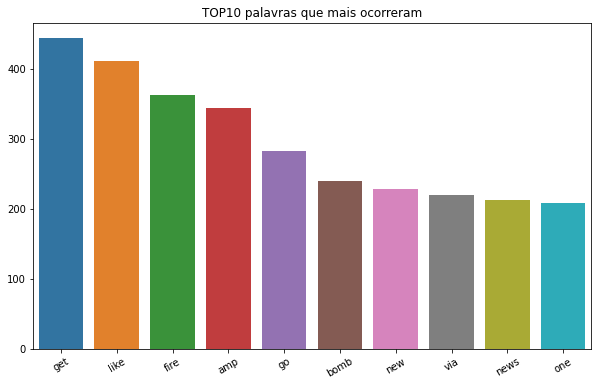

In [15]:
# colocando as palavras em um objeto do tipo lista
words_list = list(dict(words_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(words_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))
# gráfico
ax = sns.barplot(x = words_list, y = occur_list)
# título
ax.set_title('TOP10 palavras que mais ocorreram')
# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

Observando a distrubuição das classes

In [16]:
print(df_train.groupby("target").count())

          id  text  textpronto  tokens
target                                
0       4342  4342        4342    4342
1       3271  3271        3271    3271


Observando a distribuição do target, ajuda a ver o quanto está balanceado

Distribuição do target:
0    4342
1    3271
Name: target, dtype: int64


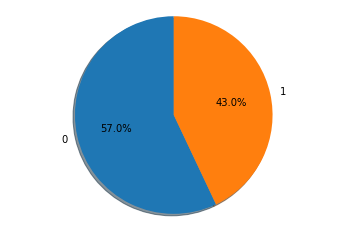

In [17]:
print('Distribuição do target:')
print(df_train['target'].value_counts())

labels = '0','1'
sizes = df_train['target'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

Informações da sentenças 

In [18]:
all_words = [word for tokens in df_train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s - Quantidade total de palavras, com um vocabulário de: %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença: %s" % max(sentence_lengths))

69702 - Quantidade total de palavras, com um vocabulário de: 12943
Tamanho máximo de uma sentença: 25


Mostra a distribuição das sentenças por quantidade de palavras

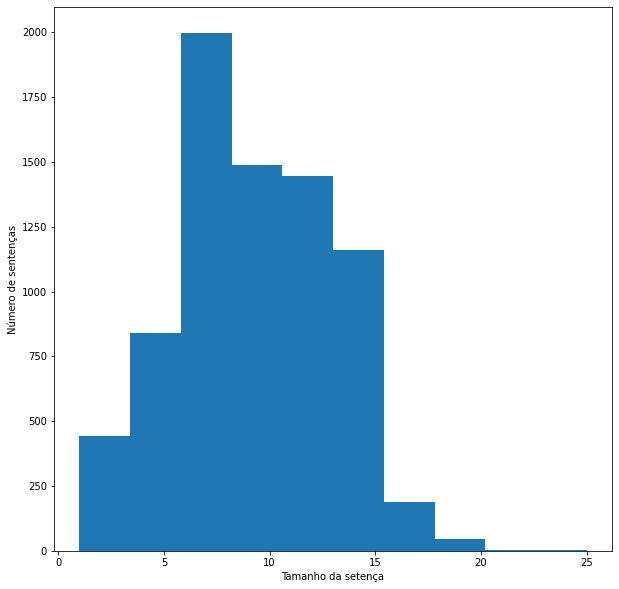

In [19]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
plt.hist(sentence_lengths)
plt.show()

**Bag-of-words:**
* Constroi uma bolsa de palavras de acordo com a ocorrência delas, sem considerar a ordem e a estrutura 

In [20]:
# Construindo bag-of-words com count-vectorizer
count_vectorizer = CountVectorizer()

# Separando o texto da variável alvo
x = df_train["textpronto"].tolist()
y = df_train["target"].tolist()

# Construindo exemplos para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=40)

# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_counts = count_vectorizer.fit_transform(X_train)
# Contabilizando os termos no vocabulário aprendido para treino
X_test_counts = count_vectorizer.transform(X_test)

Gráfico mostrando a distribuição do vocabulário por variável alvo

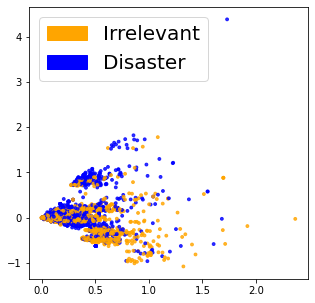

In [21]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
            
fig = plt.figure(figsize=(5, 5))          
plot_LSA(X_train_counts, y_train)
plt.show()


**TREINANDO OS CLASSIFICADORES**

1 - REGRESSÂO LOGÍSTICA

* Trassa uma curva em S;
* Tem a variável categoria podendo assumir um conjunto de dados limitados de possibilidades (0,1)

In [22]:
# Aplicando as configurações no modelo
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)

In [23]:
#Treinando o modelo com o vocabulário construido e as variáveis alvo
clf.fit(X_train_counts, y_train)

LogisticRegression(C=30.0, class_weight='balanced', multi_class='ovr',
                   n_jobs=-1, random_state=40, solver='newton-cg')

2 - MultinomialNB

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [25]:
#Treinando o modelo com o vocabulário construido e as variáveis alvo
nb.fit(X_train_counts, y_train)

MultinomialNB()

Predição para o conjunto de teste

In [26]:
y_predicted_counts = clf.predict(X_test_counts)
y_predicted_counts

array([1, 1, 1, ..., 0, 0, 0])

In [27]:
y_predicted_counts = nb.predict(X_test_counts)
y_predicted_counts

array([1, 0, 0, ..., 0, 0, 0])

AVALIANDO A REGRESSÂO LOGÍSTICA

In [28]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print('Métricas:')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Métricas:
accuracy = 0.808, precision = 0.807, recall = 0.808, f1 = 0.807


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

matriz = confusion_matrix(y_test, y_predicted_counts)
print('A matriz da regressão logística é:')
matriz

A matriz da regressão logística é:


array([[727, 125],
       [168, 503]])

PALAVRAS MAIS E MENOS USADAS PARA A TOMADA DE DECISÃO 

In [30]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

var_importantes = get_most_important_features(count_vectorizer, clf, 10)
print('As dez palavras mais e menos usadas são:')
var_importantes

As dez palavras mais e menos usadas são:


{0: {'tops': [(4.853773239328758, 'acryl'),
   (4.893341778882818, 'earthquak'),
   (5.29968309913544, 'massacr'),
   (5.377565864667575, 'choppa'),
   (5.503742543698739, 'wildfir'),
   (5.789772208122181, 'opposit'),
   (5.81186013038899, 'distanc'),
   (6.020338101279987, 'hiroshima'),
   (6.390021963454788, 'typhoon'),
   (6.542525988179359, 'disneyirh')],
  'bottom': [(-3.888194452896802, 'wizkidayo'),
   (-3.901361994592375, 'gopdeb'),
   (-3.9498293357845444, 'write'),
   (-4.064052846046794, 'fresno'),
   (-4.090712800461119, 'soul'),
   (-4.27398800801791, 'cole'),
   (-4.4633333970063935, 'success'),
   (-4.465040397741161, 'todayng'),
   (-4.841019139881758, 'wowo'),
   (-5.292247761740371, 'statist')]}}

2 - TF-IDF 

* Através de medidas estatísticas vê o quão importante uma palavra é em um documento

In [31]:
# Construindo bag-of-words com count-vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Contabilizando os termos no vocabulário aprendido para treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Gráfico mostrando a distribuição do vocabulário por variável alvo

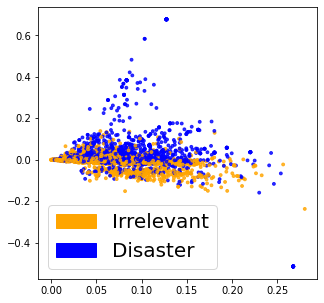

In [32]:
fig = plt.figure(figsize=(5, 5))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

Predição com TF-IDF

In [33]:
# Modelo
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)

In [34]:
nb_tfidf = MultinomialNB()

In [35]:
#Treinando o modelo com o vocabulário construido e as variáveis alvo
nb_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = nb_tfidf.predict(X_test_tfidf)

y_predicted_tfidf

array([1, 0, 0, ..., 0, 0, 0])

AVALIANDO O TF-IDF 

In [36]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print('Métricas:')
print('Métricas:',"accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

Métricas:
Métricas: accuracy = 0.805, precision = 0.809, recall = 0.805, f1 = 0.802


In [37]:
matriz2 = confusion_matrix(y_test, y_predicted_tfidf)
print('A matriz do TF-IDF é:')
matriz2

A matriz do TF-IDF é:


array([[763,  89],
       [208, 463]])

PALAVRAS MAIS E MENOS USADAS PARA A TOMADA DE DECISÃO

In [38]:
var_imp2 = get_most_important_features(tfidf_vectorizer, nb_tfidf, 10)
print('As dez palavras mais e menos usadas são:')
var_imp2

As dez palavras mais e menos usadas são:


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


{0: {'tops': [(-6.761981607104781, 'train'),
   (-6.748187551641944, 'flood'),
   (-6.721171430159302, 'home'),
   (-6.714363503443373, 'crash'),
   (-6.660223361854008, 'california'),
   (-6.652246823741697, 'suicid'),
   (-6.507333922239139, 'news'),
   (-6.380276537202098, 'kill'),
   (-6.355065983337062, 'bomb'),
   (-6.058610405569359, 'fire')],
  'bottom': [(-9.848073889982478, 'zippolin'),
   (-9.848073889982478, 'zmne'),
   (-9.848073889982478, 'zodiac'),
   (-9.848073889982478, 'zombiefunrun'),
   (-9.848073889982478, 'zoom'),
   (-9.848073889982478, 'zouma'),
   (-9.848073889982478, 'zrnf'),
   (-9.848073889982478, 'zss'),
   (-9.848073889982478, 'zumiez'),
   (-9.848073889982478, 'zzzz')]}}

**DADOS DE TESTE**

In [39]:
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


**Limpando o texto e criando os tokens** 

In [40]:
df_test['textpronto'] = df_test['text'].apply(clean_review)

df_test["tokens"] = df_test["textpronto"].apply(tokenizer.tokenize)

df_test

,id,keyword,location,text,textpronto,tokens
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash,"[happen, terribl, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquak differ citi stay safe everyon,"[hear, earthquak, differ, citi, stay, safe, ev..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...,"[forest, fire, spot, pond, gees, flee, across,..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir,"[apocalyps, light, spokan, wildfir]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquak safeti lo angel safeti fasten xrwn,"[earthquak, safeti, lo, angel, safeti, fasten,..."
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri wors last hurrican citi amp other har...,"[storm, ri, wors, last, hurrican, citi, amp, o..."
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derail chicago,"[green, line, derail, chicago]"
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issu hazard weather outlook hwo,"[meg, issu, hazard, weather, outlook, hwo]"


Excluindo as colunas location e keyword

In [41]:
df_test = df_test.drop(columns=[ 'location',
                   'keyword'])

Dividindo em x e y

In [42]:
x = df_test['textpronto']
y = df_test.drop('textpronto', axis = 1)

In [43]:
X_tfidf = tfidf_vectorizer.transform(x)

In [44]:
preds = nb_tfidf.predict(X_tfidf)
preds[:90]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1])

In [45]:
subm =pd.DataFrame({'id':df_test['id'].to_list(),'target':preds})
subm.to_csv('submission.csv',index=False)

subm[:90]

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
85,292,1
86,295,0
87,300,0
88,304,1
